In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import random
import h5py
import os
import torch.utils.data

### Networks with residual and with relu activation function

In [2]:
def to_np(x):
    return x.detach().cpu().numpy()

def cal_boundry(u, igst):
    m, n, l = u.shape
    u = torch.cat((u[:, :, -2*igst:-igst], u[:, :, igst: -igst], u[:, :, igst:2*igst]), dim=2)
    return u


class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.kernel_size = kernel_size
        self.left = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, kernel_size=kernel_size, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, kernel_size=1, padding=0),
        )
        self.shortcut = nn.Sequential()
        if inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv1d(inchannel, outchannel, kernel_size=1, padding=0),
            )

    def forward(self, x):
        if self.kernel_size == 3:
            out = self.left(F.pad(x, pad=[1, 1], mode='replicate'))
        else:
            out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ODEnet(nn.Module):
    def __init__(self, dx, igst, eps):
        super(ODEnet, self).__init__()
        self.conp = 1
        self.hide = 4
        self.igst = igst
        self.dx = dx
        self.eps = eps
        
        self.cal_lam = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                      ResidualBlock(16, 16),
                                      ResidualBlock(16, 32),
                                      ResidualBlock(32, 64),
                                      ResidualBlock(64, 64),
                                      ResidualBlock(64, 64, kernel_size=1),
                                      nn.Conv1d(64, self.hide, kernel_size=1, padding=0),
                                      )
        self.cal_L = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                    ResidualBlock(16, 16),
                                    ResidualBlock(16, 32),
                                    ResidualBlock(32, 64),
                                    ResidualBlock(64, 64),
                                    ResidualBlock(64, 64, kernel_size=1),
                                    nn.Conv1d(64, self.conp*self.hide, kernel_size=1, padding=0),
                                    )

    def cal_du(self, um):
        ul = torch.cat((um[:, :, -1:], um[:, :, :-1]), 2)
        ur = torch.cat((um[:, :, 1:], um[:, :, :1]), 2)

        data_left = torch.cat((ul, um), 1)
        data_right = torch.cat((um, ur), 1)

        lam_l = self.cal_lam(data_left).transpose(1, 2)# / 10
        lam_l = torch.diag_embed(lam_l)
        lam_r = self.cal_lam(data_right).transpose(1, 2)# / 10
        lam_r = torch.diag_embed(lam_r)

        L_l = self.cal_L(data_left).transpose(1, 2)
        L_l = L_l.reshape(L_l.shape[0], L_l.shape[1], self.hide, self.conp)
        L_r = self.cal_L(data_right).transpose(1, 2)
        L_r = L_l.reshape(L_r.shape[0], L_r.shape[1], self.hide, self.conp)

        R_l = torch.inverse((L_l.transpose(2,3))@L_l)@(L_l.transpose(2,3))
        R_r = torch.inverse((L_r.transpose(2,3))@L_r)@(L_r.transpose(2,3))
        um = um.transpose(1, 2).unsqueeze(-1)
        ul = ul.transpose(1, 2).unsqueeze(-1)
        ur = ur.transpose(1, 2).unsqueeze(-1)
        

        out = R_r @ (lam_r - lam_r.abs()) @ L_r @ (ur - um) + \
              R_l @ (lam_l + lam_l.abs()) @ L_l @ (um - ul)
        
        return -out.squeeze(-1).transpose(1, 2) / (2 * self.dx)

    def forward(self, z0, t1_t0):

        n_steps = round(t1_t0 / self.eps)
        h = t1_t0 / n_steps
        z = z0
        for i_step in range(int(n_steps)):
            z = cal_boundry(z + h * self.cal_du(z), self.igst)
        return z


device = 'cuda:0'
device = torch.device(device) if torch.cuda.is_available() else torch.device('cpu')
igst = 10
grid_size = 100
time_size = 80
xs = -0.5
xe = 0.5
lx = xe - xs
dx = lx / grid_size
DT = 0.01
f_neur = ODEnet(dx, igst, eps=0.001)
f_neur.to(device)
x0 = torch.tensor(range(grid_size), dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0) * lx / grid_size + xs
m, n, l = x0.shape
x0f = torch.zeros(m, n, l + igst * 2)
x0f[:, :, 0:igst] = x0[:, :, l - igst:l] - lx
x0f[:, :, l + igst:l + igst * 2] = x0[:, :, 0:igst] + lx
x0f[:, :, igst:l + igst] = x0[:, :, 0:l]

def to_np(x):
    return x.detach().cpu().numpy()

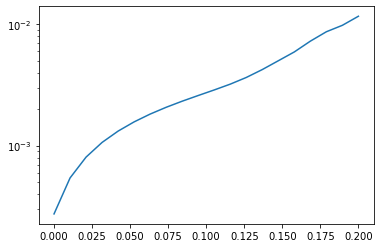

In [3]:
uR = torch.load('uRoe.dat')
uF = uR[0:1, :, :].to(device)
f_neur = ODEnet(dx, igst, eps=0.001)
f_neur.to(device)
f_neur.load_state_dict(torch.load("model.pt", map_location=lambda storage, location: storage))
uF = uR[0:1, :, :].to(device)
errs = []
for i in range(1, 21):
    uF = f_neur(uF, DT)
    err = torch.norm(uR[i, 0, 0:100].to(device) - uF[0, 0, 0:100])/100
    errs.append(err.item())
    
plt.plot(np.linspace(0, 0.2, 20), errs)
plt.yscale('log')
plt.show()

### Networks without residual and with relu activation function

In [5]:
def to_np(x):
    return x.detach().cpu().numpy()

def cal_boundry(u, igst):
    m, n, l = u.shape
    u = torch.cat((u[:, :, -2*igst:-igst], u[:, :, igst: -igst], u[:, :, igst:2*igst]), dim=2)
    return u


class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.kernel_size = kernel_size
        self.left = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, kernel_size=kernel_size, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, kernel_size=1, padding=0),
        )
        self.shortcut = nn.Sequential()
        if inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv1d(inchannel, outchannel, kernel_size=1, padding=0),
            )

    def forward(self, x):
        if self.kernel_size == 3:
            out = self.left(F.pad(x, pad=[1, 1], mode='replicate'))
        else:
            out = self.left(x)
        # out += self.shortcut(x)
        out = F.relu(out)
        return out


class ODEnet(nn.Module):
    def __init__(self, dx, igst, eps):
        super(ODEnet, self).__init__()
        self.conp = 1
        self.hide = 4
        self.igst = igst
        self.dx = dx
        self.eps = eps
        
        self.cal_lam = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                      ResidualBlock(16, 16),
                                      ResidualBlock(16, 32),
                                      ResidualBlock(32, 64),
                                      ResidualBlock(64, 64),
                                      ResidualBlock(64, 64, kernel_size=1),
                                      nn.Conv1d(64, self.hide, kernel_size=1, padding=0),
                                      )
        self.cal_L = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                    ResidualBlock(16, 16),
                                    ResidualBlock(16, 32),
                                    ResidualBlock(32, 64),
                                    ResidualBlock(64, 64),
                                    ResidualBlock(64, 64, kernel_size=1),
                                    nn.Conv1d(64, self.conp*self.hide, kernel_size=1, padding=0),
                                    )


    def cal_du(self, um):
        ul = torch.cat((um[:, :, -1:], um[:, :, :-1]), 2)
        ur = torch.cat((um[:, :, 1:], um[:, :, :1]), 2)

        data_left = torch.cat((ul, um), 1)
        data_right = torch.cat((um, ur), 1)

        lam_l = self.cal_lam(data_left).transpose(1, 2)# / 10
        lam_l = torch.diag_embed(lam_l)
        lam_r = self.cal_lam(data_right).transpose(1, 2)# / 10
        lam_r = torch.diag_embed(lam_r)

        L_l = self.cal_L(data_left).transpose(1, 2)
        L_l = L_l.reshape(L_l.shape[0], L_l.shape[1], self.hide, self.conp)
        L_r = self.cal_L(data_right).transpose(1, 2)
        L_r = L_l.reshape(L_r.shape[0], L_r.shape[1], self.hide, self.conp)

        R_l = torch.inverse((L_l.transpose(2,3))@L_l)@(L_l.transpose(2,3))
        R_r = torch.inverse((L_r.transpose(2,3))@L_r)@(L_r.transpose(2,3))
        um = um.transpose(1, 2).unsqueeze(-1)
        ul = ul.transpose(1, 2).unsqueeze(-1)
        ur = ur.transpose(1, 2).unsqueeze(-1)
        

        out = R_r @ (lam_r - lam_r.abs()) @ L_r @ (ur - um) + \
              R_l @ (lam_l + lam_l.abs()) @ L_l @ (um - ul)
        

        return -out.squeeze(-1).transpose(1, 2) / (2 * self.dx)

    def forward(self, z0, t1_t0):

        n_steps = round(t1_t0 / self.eps)
        h = t1_t0 / n_steps
        z = z0
        for i_step in range(int(n_steps)):
            z = cal_boundry(z + h * self.cal_du(z), self.igst)
        return z


device = 'cuda:0'
device = torch.device(device) if torch.cuda.is_available() else torch.device('cpu')
igst = 10
grid_size = 100
time_size = 80
xs = -0.5
xe = 0.5
lx = xe - xs
dx = lx / grid_size
DT = 0.01
f_neur_conv = ODEnet(dx, igst, eps=0.001)
f_neur_conv.to(device)
x0 = torch.tensor(range(grid_size), dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0) * lx / grid_size + xs
m, n, l = x0.shape
x0f = torch.zeros(m, n, l + igst * 2)
x0f[:, :, 0:igst] = x0[:, :, l - igst:l] - lx
x0f[:, :, l + igst:l + igst * 2] = x0[:, :, 0:igst] + lx
x0f[:, :, igst:l + igst] = x0[:, :, 0:l]

def to_np(x):
    return x.detach().cpu().numpy()



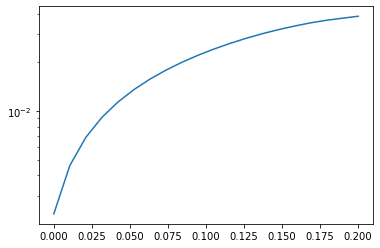

In [6]:
uR = torch.load('uRoe.dat')
uF = uR[0:1, :, :].to(device)
f_neur_conv = ODEnet(dx, igst, eps=0.001)
f_neur_conv.to(device)
f_neur_conv.load_state_dict(torch.load("model_conv.pt", map_location=lambda storage, location: storage))
uF = uR[0:1, :, :].to(device)
errs_conv = []
for i in range(1, 21):
    uF = f_neur_conv(uF, DT)
    err = torch.norm(uR[i, 0, 0:100].to(device) - uF[0, 0, 0:100])/100
    errs_conv.append(err.item())
    
plt.plot(np.linspace(0, 0.2, 20), errs_conv)
plt.yscale('log')
plt.show()

### Networks with residual and with identity activation function

In [8]:
def to_np(x):
    return x.detach().cpu().numpy()

def cal_boundry(u, igst):
    m, n, l = u.shape
    u = torch.cat((u[:, :, -2*igst:-igst], u[:, :, igst: -igst], u[:, :, igst:2*igst]), dim=2)
    return u


class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.kernel_size = kernel_size
        self.left = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, kernel_size=kernel_size, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, kernel_size=1, padding=0),
        )
        self.shortcut = nn.Sequential()
        if inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv1d(inchannel, outchannel, kernel_size=1, padding=0),
            )

    def forward(self, x):
        if self.kernel_size == 3:
            out = self.left(F.pad(x, pad=[1, 1], mode='replicate'))
        else:
            out = self.left(x)
        out += self.shortcut(x)
        # out = F.relu(out)
        return out


class ODEnet(nn.Module):
    def __init__(self, dx, igst, eps):
        super(ODEnet, self).__init__()
        self.conp = 1
        self.hide = 4
        self.igst = igst
        self.dx = dx
        self.eps = eps
        
        self.cal_lam = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                      ResidualBlock(16, 16),
                                      ResidualBlock(16, 32),
                                      ResidualBlock(32, 64),
                                      ResidualBlock(64, 64),
                                      ResidualBlock(64, 64, kernel_size=1),
                                      nn.Conv1d(64, self.hide, kernel_size=1, padding=0),
                                      )
        self.cal_L = nn.Sequential(ResidualBlock(self.conp*2, 16),
                                    ResidualBlock(16, 16),
                                    ResidualBlock(16, 32),
                                    ResidualBlock(32, 64),
                                    ResidualBlock(64, 64),
                                    ResidualBlock(64, 64, kernel_size=1),
                                    nn.Conv1d(64, self.conp*self.hide, kernel_size=1, padding=0),
                                    )

    def cal_du(self, um):
        ul = torch.cat((um[:, :, -1:], um[:, :, :-1]), 2)
        ur = torch.cat((um[:, :, 1:], um[:, :, :1]), 2)

        data_left = torch.cat((ul, um), 1)
        data_right = torch.cat((um, ur), 1)

        lam_l = self.cal_lam(data_left).transpose(1, 2)# / 10
        lam_l = torch.diag_embed(lam_l)
        lam_r = self.cal_lam(data_right).transpose(1, 2)# / 10
        lam_r = torch.diag_embed(lam_r)

        L_l = self.cal_L(data_left).transpose(1, 2)
        L_l = L_l.reshape(L_l.shape[0], L_l.shape[1], self.hide, self.conp)
        L_r = self.cal_L(data_right).transpose(1, 2)
        L_r = L_l.reshape(L_r.shape[0], L_r.shape[1], self.hide, self.conp)


        R_l = torch.inverse((L_l.transpose(2,3))@L_l)@(L_l.transpose(2,3))
        R_r = torch.inverse((L_r.transpose(2,3))@L_r)@(L_r.transpose(2,3))
        um = um.transpose(1, 2).unsqueeze(-1)
        ul = ul.transpose(1, 2).unsqueeze(-1)
        ur = ur.transpose(1, 2).unsqueeze(-1)
        

        out = R_r @ (lam_r - lam_r.abs()) @ L_r @ (ur - um) + \
              R_l @ (lam_l + lam_l.abs()) @ L_l @ (um - ul)
        
        return -out.squeeze(-1).transpose(1, 2) / (2 * self.dx)

    def forward(self, z0, t1_t0):

        n_steps = round(t1_t0 / self.eps)
        h = t1_t0 / n_steps
        z = z0
        for i_step in range(int(n_steps)):

            z = cal_boundry(z + h * self.cal_du(z), self.igst)
        return z


device = 'cuda:0'
device = torch.device(device) if torch.cuda.is_available() else torch.device('cpu')
igst = 10
grid_size = 100
time_size = 80
xs = -0.5
xe = 0.5
lx = xe - xs
dx = lx / grid_size
DT = 0.01
f_neur = ODEnet(dx, igst, eps=0.001)
f_neur.to(device)
x0 = torch.tensor(range(grid_size), dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0) * lx / grid_size + xs
m, n, l = x0.shape
x0f = torch.zeros(m, n, l + igst * 2)
x0f[:, :, 0:igst] = x0[:, :, l - igst:l] - lx
x0f[:, :, l + igst:l + igst * 2] = x0[:, :, 0:igst] + lx
x0f[:, :, igst:l + igst] = x0[:, :, 0:l]

def to_np(x):
    return x.detach().cpu().numpy()





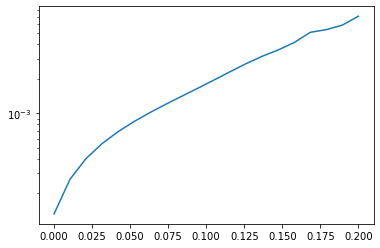

In [64]:
uR = torch.load('uRoe.dat')
uF = uR[0:1, :, :].to(device)
f_neur_idAct = ODEnet(dx, igst, eps=0.001)
f_neur_idAct.to(device)
f_neur_idAct.load_state_dict(torch.load("model_idAct.pt", map_location=lambda storage, location: storage))
uF = uR[0:1, :, :].to(device)
errs_idAct = []
for i in range(1, 21):
    uF = f_neur_idAct(uF, DT)
    err = torch.norm(uR[i, 0, 0:100].to(device) - uF[0, 0, 0:100])/100
    errs_idAct.append(err.item())
    
plt.plot(np.linspace(0, 0.2, 20), errs_idAct)
plt.yscale('log')
plt.show()

In [52]:
import pandas as pd

errs1 = pd.DataFrame(np.array(errs).reshape(-1, 1))
errs_conv1 = pd.DataFrame(np.array(errs_conv).reshape(-1, 1))
errs_idAct1 = pd.DataFrame(np.array(errs_idAct).reshape(-1, 1))

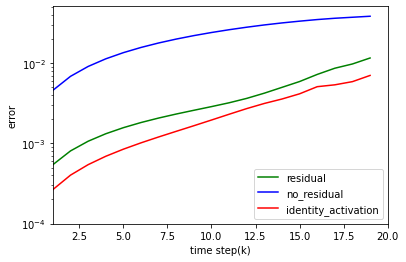

In [86]:
import seaborn as sns

fig1, ax2 = plt.subplots(1, 1)
# ax2.plot(np.linspace(0.01, 0.2, 20), errs, co)
p1 = sns.lineplot(data=errs, ax=ax2, color='g', label="residual")
p2 = sns.lineplot(data=errs_conv, ax=ax2, color='b', label='no_residual')
p3 = sns.lineplot(data=errs_idAct, ax=ax2, color='r', label='identity_activation')
# ax2.set_xticks([0, 100*4/19, 100*8/19, 100*11/19, 100*15/19, 100])
# ax2.set_xticklabels([0.01, 0.05, 0.09, 0.12, 0.16, 0.2])
plt.yscale('log')
p1.set_xlim(1, 20)
p1.set_xlabel('time step(k)')
p1.set_ylabel('error')
plt.savefig('error')
plt.show()